In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')
from utils.helpers import OCRD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def run_ocrd_pipeline(img_path, binarize_mode='detailed', min_pixel_sum='default', median_bounds='default', font_size='default'):
    """
    Executes the OCRD pipeline on an image from file loading to text overlay creation. This function orchestrates
    the calling of various OCRD class methods to process the image, extract and recognize text, and then overlay
    this text on the original image.

    Parameters:
        img_path (str): Path to the image file.
        binarize_mode (str): Mode to be used for image binarization. Can be 'detailed', 'fast', or 'no'.
        min_pixel_sum (int, optional): Minimum sum of pixels to consider a text line segmentation for extraction. 
            If 'default', default values are applied.
        median_bounds (tuple, optional): Bounds to filter text line segmentations based on size relative to the median. 
            If 'default', default values are applied.
        font_size (int, optional): Font size to be used in text overlay. If 'default', a default size or scaling logic is applied.

    Returns:
        Image: An image with overlay text, where text is extracted and recognized from the original image.

    This function handles:
    - Image binarization.
    - Text line segmentation.
    - Text line extraction and deskewing.
    - Optical character recognition on text lines.
    - Creating an image overlay with recognized text.
    """
    
    # prepare kwargs
    efadt_kwargs = {}
    if min_pixel_sum != 'default':
        efadt_kwargs['min_pixel_sum'] = min_pixel_sum
    if median_bounds != 'default':
        efadt_kwargs['median_bounds'] = median_bounds

    ctoi_kwargs = {}
    if font_size != 'default':
        ctoi_kwargs['font_size'] = font_size

    # run pipeline
    ocrd = OCRD(img_path)
    print('\nBinarizing image...\n')
    binarized = ocrd.binarize_image(ocrd.image, binarize_mode)
    print('\nSegmenting textlines...\n')
    textline_segments = ocrd.segment_textlines(binarized)
    print('\nExtracting, filtering and de-skewing textlines...\n')
    image_scaled = ocrd.scale_image(ocrd.image)  # textline_segments were predicted on rescaled image
    textline_images, _ = ocrd.extract_filter_and_deskew_textlines(image_scaled, textline_segments[...,0], **efadt_kwargs)
    print('\nOCR on textlines...\n')
    textline_preds = ocrd.ocr_on_textlines(textline_images)
    print('\nCreating output overlay image...')
    img_gen = ocrd.create_text_overlay_image(textline_images, textline_preds, (image_scaled.shape[0], image_scaled.shape[1]), **ctoi_kwargs)
    print('\nJOB COMPLETED\n')

    return img_gen

In [4]:
img_path = '../src/test_data_english/act_image.jpg'
binarize_mode = 'detailed' # 'detailed', 'fast', 'no'
min_pixel_sum = 50 # for textline segments filtering
median_bounds = (None, None) # for textline segments filtering
font_size = 30 # for generated result image (-1 for dynamic font size)

In [6]:
img_gen = run_ocrd_pipeline(img_path, binarize_mode, min_pixel_sum, median_bounds, font_size)

Binarizing image...



Fetching 6 files: 100%|██████████| 6/6 [00:00<?, ?it/s]


c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\keras\src\layers\core\lambda_layer.py:327: UserWarning: keras.layers.core is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


Segmenting textlines...



Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5943.75it/s]
c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\keras\src\layers\core\lambda_layer.py:327: UserWarning: keras.layers.core is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


Extracing, filtering and de-skewing textlines...

Kept 53 of 74 text segments after filtering.
All segments deleted smaller than 50 pixels (absolute min size).
OCR on textlines...



Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Processing textline no. 1 of 53
Processing textline no. 11 of 53
Processing textline no. 21 of 53
Processing textline no. 31 of 53
Processing textline no. 41 of 53
Processing textline no. 51 of 53
Creating output overlay image...


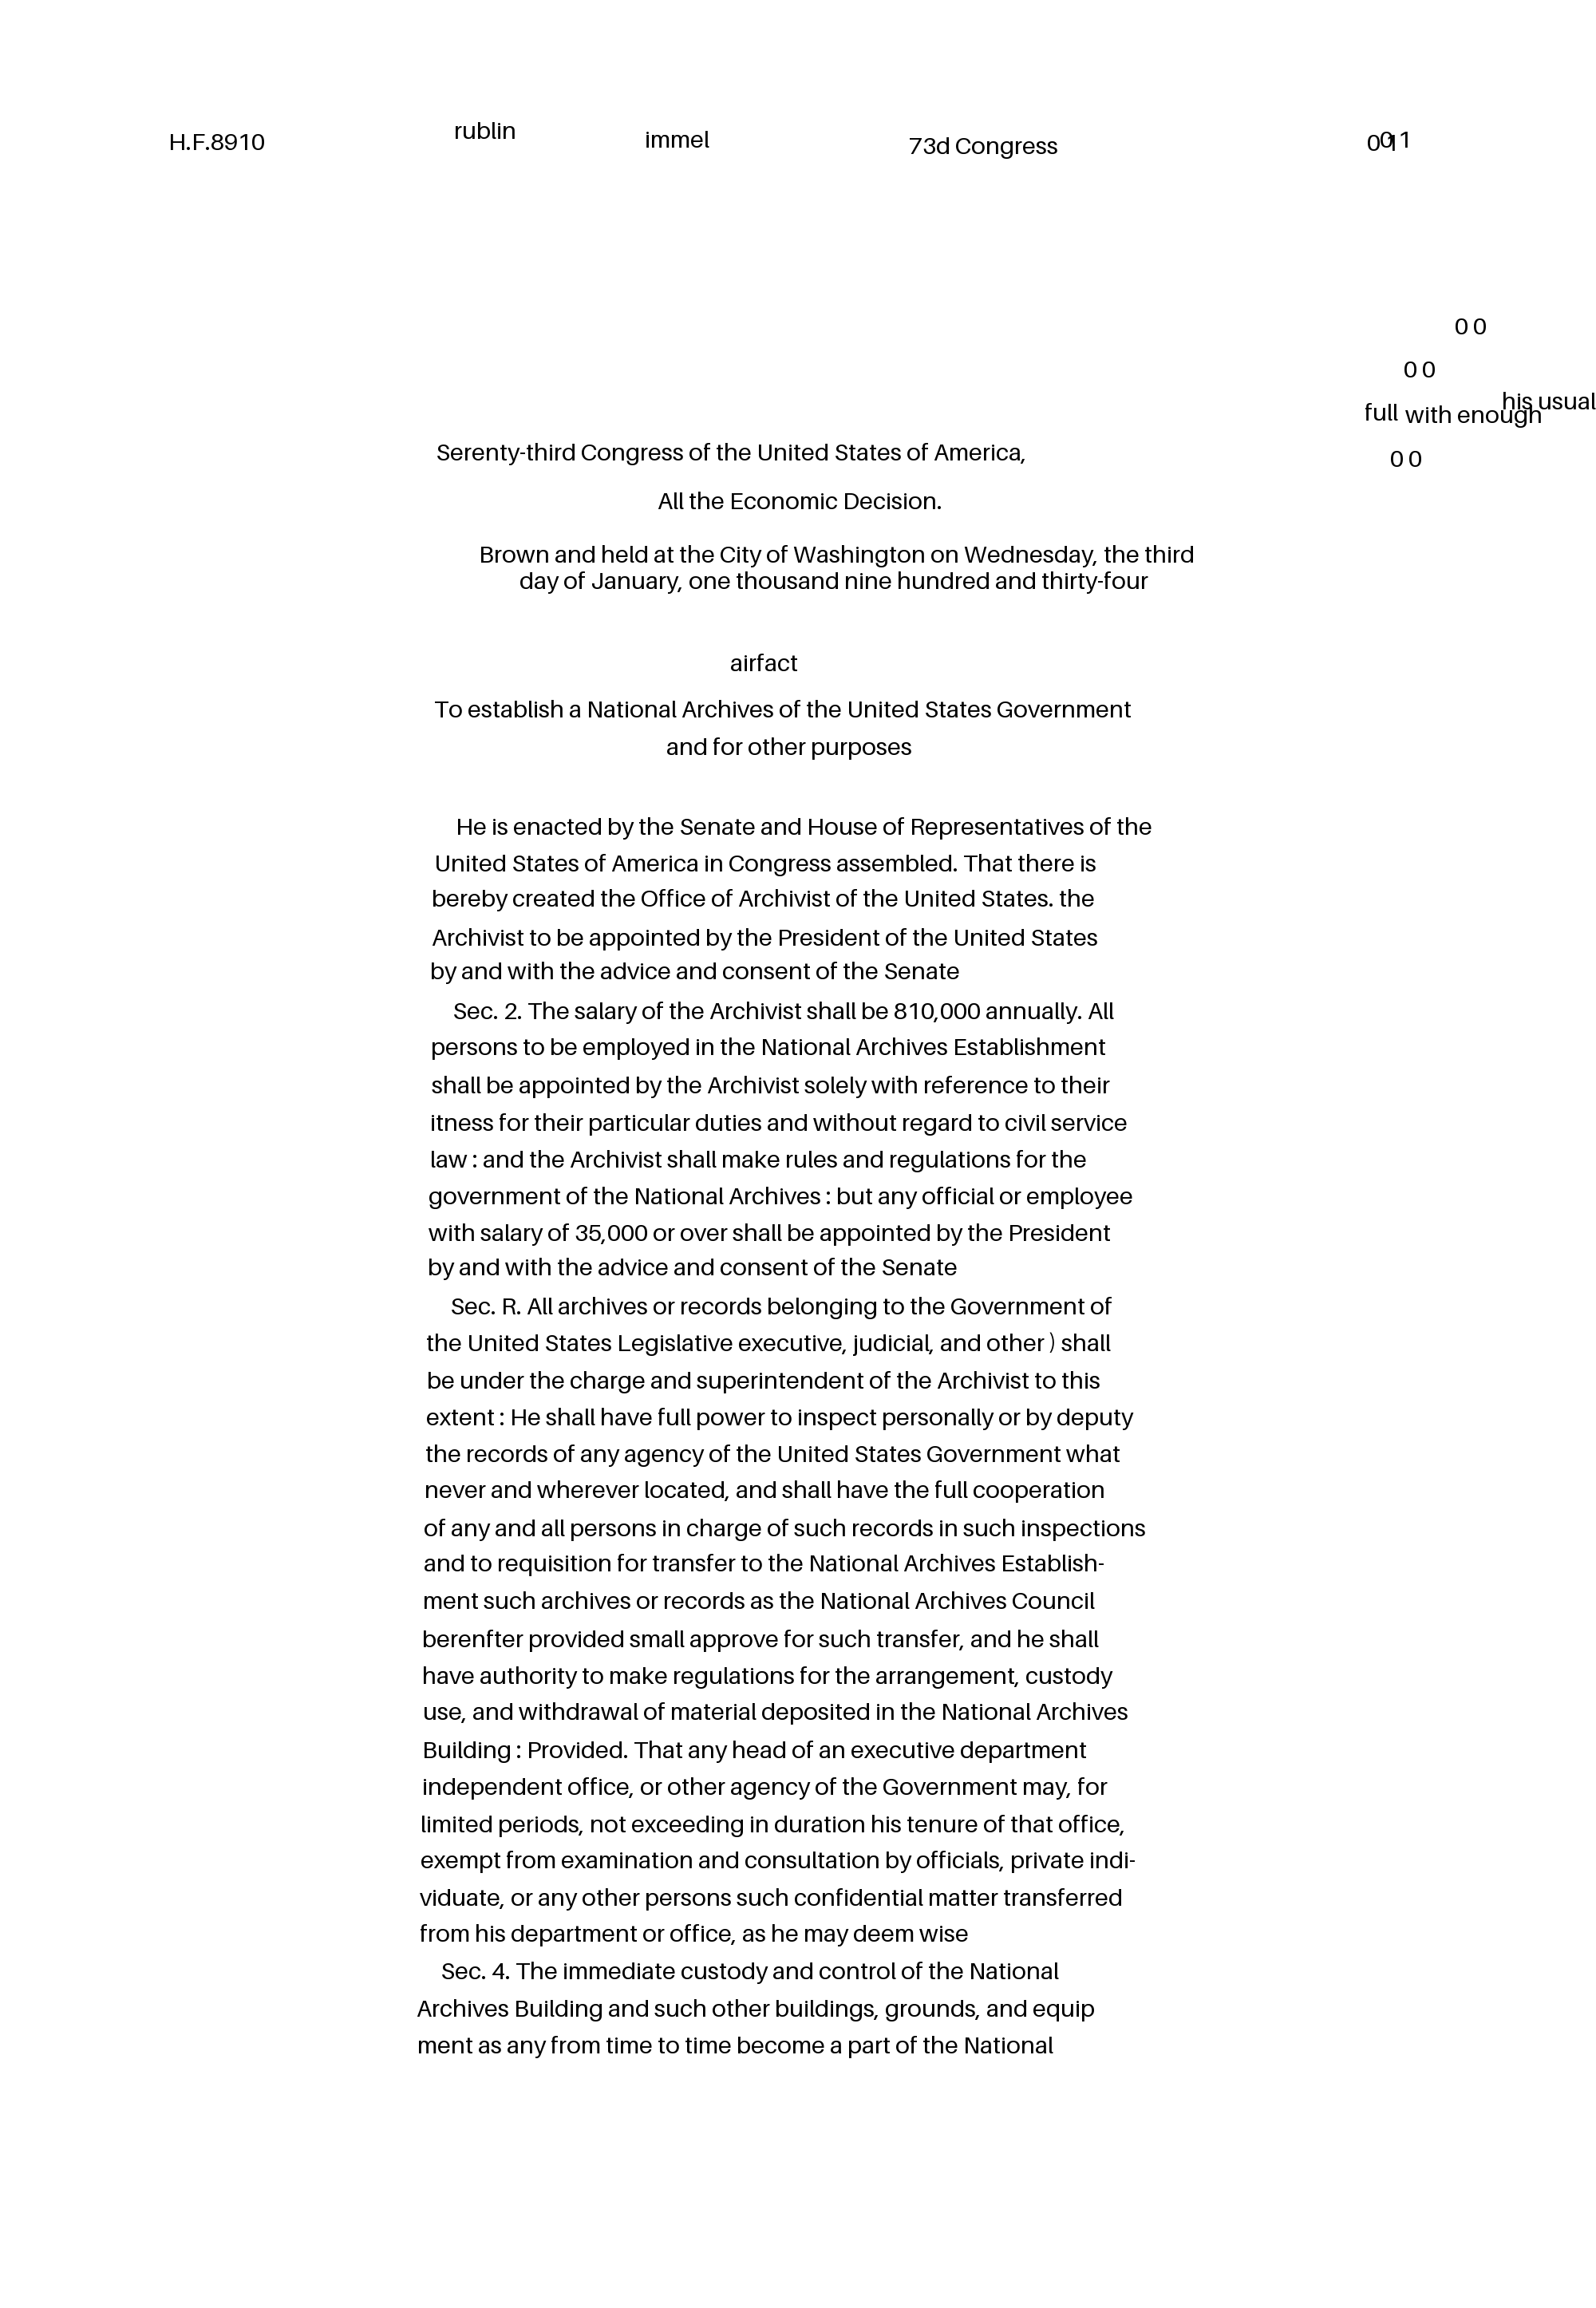

In [7]:
img_gen